In [1]:
# region ----------Imports ----------
from SnakeBoard import SnakeBoard
from SnakeGame import SnakeGame
from NeuralNetwork import NeuralNetwork
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import shutil
import pygame
import copy
from IPython.display import display, clear_output
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
#endregion

# Decay function for bias and weight mutation reduction
def decay_function(epoch, max_epoch, fin_rate, tau = 1):
    return (1-fin_rate) * np.exp(-tau*(epoch/max_epoch)) + fin_rate

# Run a game instance following the ANN inputs until it's "Game Over"
def play_game_instance(game, ann, idx):
    while True:
        # Get current game state 
        state = game.get_game_state()
        
        # Feed ANN with game state and calc. next move
        next_move = ann.calculate(state) 

        # Step game based on ANN input
        [game_over, w_score, score] = game.step_game(next_move)
        
        if game_over:
            break # End of the game!
    
    return [game_over, w_score, score, idx]

# Run all game instances in parallel
def run_games_parallel(s_games, s_ann):
    game_status = list() 
    # Go into each game to step individually (parallel)
    with ThreadPoolExecutor() as executor:
        # Play game instance until finishing / game-over
        futures = [executor.submit(play_game_instance,
                                   s_games[idx_game],
                                   s_ann[idx_game], 
                                   idx_game) for idx_game in range(len(s_games))]

        # Collect the results for each played game instance
        [game_status.append({
            "game_over":    future.result()[0], 
            "w_score":      future.result()[1], 
            "score":        future.result()[2],
            "idx_game":     future.result()[3]}) for future in futures]  
    
    return game_status

# Run all game instances concomitantly in series (as a 'RTOS scheduler')
def run_games_series(s_games, s_ann, s_board, show_visuals, manual_play):
    while True:     
        game_status = list() 
        # Go into each game to step individually (series)
        for idx_game in range(len(s_games)):
            # Get current game state 
            state = s_games[idx_game].get_game_state()
           
            # If showing visuals, get key
            # (even in auto-play mode it's important to don't freeze - pygame needs to be queried to events every ~5s)
            if show_visuals:
                next_move = get_key()            
            
            # Detect pause behavior
            if manual_play == 1 and next_move == "PAUSE":
                while 1:
                    next_move = get_key()
                    if next_move != "IDLE":
                        break                    
            elif manual_play == 0:    
                # Feed ANN with game state and calc. next move
                next_move = s_ann[idx_game].calculate(state) 

            # Step game based on ANN input 
            [game_over, w_score, score] = s_games[idx_game].step_game(next_move)

            # Collect the results for each played game instance
            game_status.append({"game_over":    game_over, 
                                "score":        score, 
                                "w_score":      w_score, 
                                "idx_game":     idx_game})       

        # Update graphics of all games (visual feedback)
        s_board.clear_board()
        s_board.update_board_elements()

        # If all game instances are over, finish current generation
        if np.min([g["game_over"] for g in game_status])==True:
            break
    
    return game_status
    
# Get key event for manual play    
def get_key():
    for event in pygame.event.get():
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_UP:
                return 'UP'
            if event.key == pygame.K_DOWN:
                return 'DOWN'
            if event.key == pygame.K_LEFT:
                return 'LEFT'
            if event.key == pygame.K_RIGHT:
                return 'RIGHT'
            if event.key == pygame.K_p:
                return 'PAUSE'
            if event.key == pygame.K_SPACE:
                pygame.quit()
                quit()
    return 'IDLE'
    
# Live plot of training parameters   
def live_plot(x, ys_list, labels_list, titles, num_plots=1):
    # Create figure and subplots
    if num_plots>1:
        fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots, 5))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(10,8))
        
    # Ensure axes is always a list (for single subplot case)
    if num_plots == 1:
        axes = [axes]
    
    for ax in axes:
        ax.clear()
    
    # Update the plots
    if num_plots > 1:
        for ax, ys, labels, title in zip(axes, ys_list, labels_list, titles):
            #for y, label in zip(ys, labels):
            ax.plot(x, ys, label=labels)
            ax.set_title(title)
            ax.set_xlabel('Generations')
            ax.set_ylabel('Value')
            ax.legend()
            #ax.set_xticks(range(int(min(x)), int(max(x))+1))
            #ax.set_yticks(range(int(min(ys)), int(max(ys))+1))
    else:
        ax = axes[0]
        title=titles[0]
        for ys, labels in zip(ys_list, labels_list):
            #for y, label in zip(ys, labels):
            ax.plot(x, ys, label=labels)
            ax.set_title(title)
            ax.set_xlabel('Generations')
            ax.set_ylabel('Value')
            ax.legend()
            #ax.set_xticks(range(int(min(x)), int(max(x))+1))
            #ax.set_yticks(range(int(min(ys)), int(max(ys))+1))            
    
    clear_output(wait=True)  # Clear the previous output in the notebook
    display(fig)  # Display the updated plot
    plt.close(fig)  # Close the figure to avoid duplicate display

pygame 2.6.1 (SDL 2.28.4, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


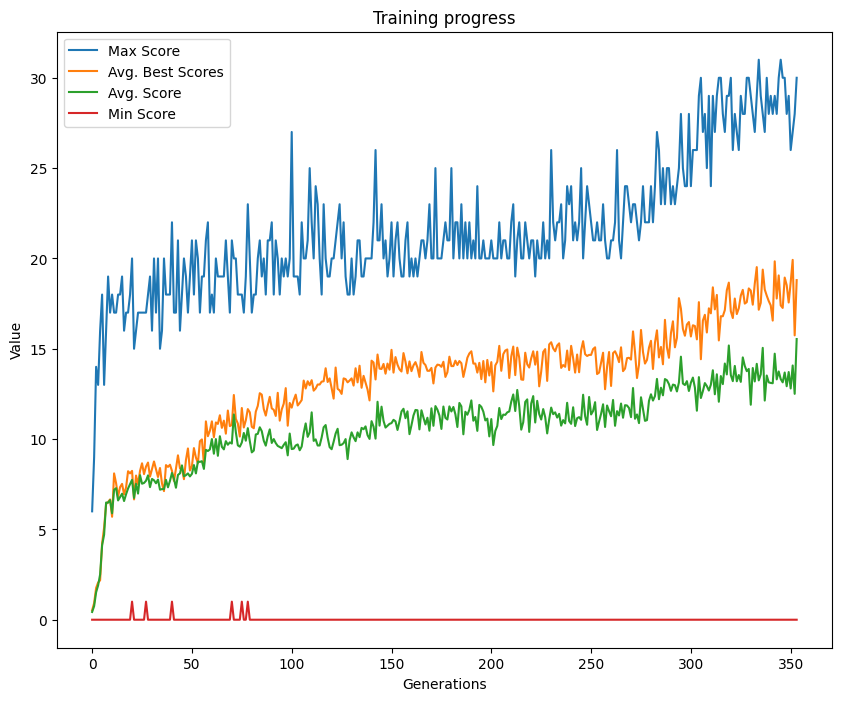

GEN  353  --- BEST SCORE:  28  /  1837  --- RECORD:  31  /  1950


In [ ]:
# region ---------- User defined parameters ----------
# Miscellaneous parameters
parallel_mode = False # Use parallel mode for training (not compatible with visuals or manual play)
restore_weights_prev_training = 0
manual_play = 0 # Get user input (keyboard) instead of neural network auto-play
show_visuals = True # Show the games (1) or just play and calculated in the back-end (0)
t_between_gen = 0 # Time (secs) between generations
n_gens_2_save_weights = 10 # Num of generations elapsed to save weights in a file

# Training parameters
n_of_gens = 10000 # Number of training generations
n_games_per_gen = 121 # Number of parallel games per generation
selected_games_per_gen = 50 # Selected baselines per generation to be used as references for mutations

# Mutation parameters
mrate_bias, mrate_weights = 0.02, 0.02
msize_bias, msize_weights = 0.9, 0.9

#endregion

# region ---------- Machine Learning main logic ---------- 
# Get current timestamp + create history directory
current_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
experiments_dir = f"experiment_data_testdel3"
# Check if the directory exists
if os.path.exists(experiments_dir):
    # Remove the directory and its contents
    shutil.rmtree(experiments_dir)
# Create the new directory
os.makedirs(experiments_dir)
print(f"Directory '{experiments_dir}' recreated successfully.")

# Restore weights from previous training if required
if restore_weights_prev_training == 1:
    pass # TODO

# Create 'N' games + their ANN instances + status variables
record_score, record_w_score = 0,0
gen_summary = {}
s_games, s_ann = [] , []
for idx in range(n_games_per_gen):
    s_games.append(SnakeGame())
    s_ann.append(NeuralNetwork())
    if restore_weights_prev_training == 1:
        pass # TODO
s_board = SnakeBoard(s_games, show_visuals)

# Create history of the best scores and ANN weights
gen_summary_history = list()
if restore_weights_prev_training == 1:
    pass # TODO

# Init + Run number of generations
s_board.init_board()
for idx_gen in range(n_of_gens):
    # Play all games in current generation (until all games are over)
    if parallel_mode:
        game_status = run_games_parallel(s_games, s_ann)
    else:
        game_status = run_games_series(s_games, s_ann, s_board, show_visuals, manual_play)
    
    # Create a summary of training progress
    scores = [gs['score'] for gs in game_status]
    gen_summary.update({
        'gen': idx_gen,
        'scores': scores,
        'best_scores': scores[0:selected_games_per_gen],
        'max_score': np.max(scores),
        'min_score': np.min(scores),
        'avg_scores': np.mean(scores),
        'avg_best_scores': np.mean(scores[0:selected_games_per_gen]),
        'median_scores': np.median(scores),
        'median_best_scores': np.median(scores[0:selected_games_per_gen]),
        'std_scores': np.std(scores),
        'std_best_scores': np.std(scores[0:selected_games_per_gen])
    })
    gen_summary_history.append(copy.deepcopy(gen_summary))
    
    # Plot Training stats in liveplot graph
    live_plot([gsh['gen'] for gsh in gen_summary_history],
              [
                [gsh['max_score'] for gsh in gen_summary_history],
                [gsh['avg_best_scores'] for gsh in gen_summary_history],
                [gsh['avg_scores'] for gsh in gen_summary_history],
                [gsh['min_score'] for gsh in gen_summary_history]
              ], 
             ["Max Score", "Avg. Best Scores", "Avg. Score", "Min Score"], ["Training progress"], num_plots=1)
    
    # Reorder the 'game_status' array to have the best performing ones first
    game_status.sort(key=lambda x:x["w_score"], reverse=True) 

    # Reorder the 'ANNs' array to have the best performing ones first
    s_ann = list(np.array(s_ann)[[e['idx_game'] for e in game_status]])

    # If best score in curr. gen is an all-time record, save it
    if game_status[0]["score"] > record_score: 
        record_w_score = game_status[0]["w_score"]
        record_score = game_status[0]["score"]   
    
    # Mutate the best performing ANNs in the subsequent positions
    decay_fac = decay_function(idx_gen,n_of_gens,0.01,3)
    for idx_dest in range(selected_games_per_gen, n_games_per_gen):
        idx_ref = np.mod(idx_dest,selected_games_per_gen)
        s_ann[idx_dest].set_weights_biases(s_ann[idx_ref].weights, s_ann[idx_ref].biases)
        s_ann[idx_dest].mutate(mrate_weights, msize_weights*decay_fac, mrate_bias, msize_bias*decay_fac) # random mutations

    # Reset all games
    for game in s_games:
        game.reset_game()

    # Save weights + game_status of current generation in files
    if np.mod(idx_gen,n_gens_2_save_weights)==0:
        for i, ann in enumerate(s_ann[0:]):
            ann.save_weights_biases(os.path.join(experiments_dir, f"Gen_{idx_gen}", f"ANN_{i}_score_{game_status[i]['score']}"))
        np.savez(os.path.join(experiments_dir, f"Gen_{idx_gen}", "game_status.npz"), game_status=np.array(game_status, dtype=object))          
        np.savez(os.path.join(experiments_dir, f"Gen_{idx_gen}", "s_ann.npz"), s_ann=np.array(s_ann, dtype=object))          
    
    print("GEN ", idx_gen, " --- BEST SCORE: ", game_status[0]["score"] , " / ", game_status[0]["w_score"] , " --- RECORD: ", record_score, " / ", record_w_score)
    time.sleep(t_between_gen)
s_board.quit_board()

# Keep the final plot
plt.ioff()
plt.show()
# endregion